In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [4]:
# load in the data
input_texts = []
target_texts = []
for line in open('../hmm_class/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [5]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [6]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [7]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [8]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [10]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
# with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
with open(os.path.join(r'C:\Users\Kirti\machine_learning_examples\glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [13]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)


In [14]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...


In [15]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/2000
9/9 [==============================] - 4s 451ms/step - loss: 5.4266 - accuracy: 0.0198 - val_loss: 5.1410 - val_accuracy: 0.0113
Epoch 2/2000
9/9 [==============================] - 3s 314ms/step - loss: 4.6914 - accuracy: 0.0249 - val_loss: 4.8424 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 3s 291ms/step - loss: 4.3966 - accuracy: 0.0833 - val_loss: 4.9396 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 2s 264ms/step - loss: 4.3327 - accuracy: 0.0833 - val_loss: 4.9434 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 2s 248ms/step - loss: 4.2795 - accuracy: 0.0833 - val_loss: 4.9386 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 2s 252ms/step - loss: 4.2245 - accuracy: 0.0833 - val_loss: 4.8999 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 3s 283ms/step - loss: 4.1523 - accuracy: 0.0833 - val_loss: 4.8402 - val_accur

9/9 [==============================] - 3s 291ms/step - loss: 2.5281 - accuracy: 0.2242 - val_loss: 5.1509 - val_accuracy: 0.0995
Epoch 59/2000
9/9 [==============================] - 3s 293ms/step - loss: 2.5089 - accuracy: 0.2266 - val_loss: 5.1540 - val_accuracy: 0.0987
Epoch 60/2000
9/9 [==============================] - 3s 320ms/step - loss: 2.4907 - accuracy: 0.2281 - val_loss: 5.1713 - val_accuracy: 0.0987
Epoch 61/2000
9/9 [==============================] - 3s 327ms/step - loss: 2.4725 - accuracy: 0.2308 - val_loss: 5.1833 - val_accuracy: 0.0998
Epoch 62/2000
9/9 [==============================] - 3s 330ms/step - loss: 2.4560 - accuracy: 0.2326 - val_loss: 5.1870 - val_accuracy: 0.0992
Epoch 63/2000
9/9 [==============================] - 3s 300ms/step - loss: 2.4385 - accuracy: 0.2329 - val_loss: 5.1981 - val_accuracy: 0.1007
Epoch 64/2000
9/9 [==============================] - 3s 300ms/step - loss: 2.4216 - accuracy: 0.2373 - val_loss: 5.2075 - val_accuracy: 0.0992
Epoch 65/2000

9/9 [==============================] - 2s 230ms/step - loss: 1.8475 - accuracy: 0.3117 - val_loss: 5.6758 - val_accuracy: 0.0897
Epoch 116/2000
9/9 [==============================] - 2s 240ms/step - loss: 1.8391 - accuracy: 0.3148 - val_loss: 5.6811 - val_accuracy: 0.0894
Epoch 117/2000
9/9 [==============================] - 3s 304ms/step - loss: 1.8329 - accuracy: 0.3142 - val_loss: 5.6913 - val_accuracy: 0.0885
Epoch 118/2000
9/9 [==============================] - 3s 281ms/step - loss: 1.8259 - accuracy: 0.3158 - val_loss: 5.7062 - val_accuracy: 0.0903
Epoch 119/2000
9/9 [==============================] - 2s 235ms/step - loss: 1.8178 - accuracy: 0.3145 - val_loss: 5.7135 - val_accuracy: 0.0891
Epoch 120/2000
9/9 [==============================] - 2s 248ms/step - loss: 1.8108 - accuracy: 0.3195 - val_loss: 5.7232 - val_accuracy: 0.0897
Epoch 121/2000
9/9 [==============================] - 2s 264ms/step - loss: 1.8024 - accuracy: 0.3211 - val_loss: 5.7286 - val_accuracy: 0.0885
Epoch 1

Epoch 172/2000
9/9 [==============================] - 3s 286ms/step - loss: 1.5086 - accuracy: 0.3715 - val_loss: 6.0810 - val_accuracy: 0.0793
Epoch 173/2000
9/9 [==============================] - 2s 249ms/step - loss: 1.5036 - accuracy: 0.3758 - val_loss: 6.0868 - val_accuracy: 0.0804
Epoch 174/2000
9/9 [==============================] - 4s 433ms/step - loss: 1.4988 - accuracy: 0.3758 - val_loss: 6.0930 - val_accuracy: 0.0790
Epoch 175/2000
9/9 [==============================] - 3s 302ms/step - loss: 1.4941 - accuracy: 0.3770 - val_loss: 6.1045 - val_accuracy: 0.0799
Epoch 176/2000
9/9 [==============================] - 3s 358ms/step - loss: 1.4900 - accuracy: 0.3759 - val_loss: 6.0988 - val_accuracy: 0.0799
Epoch 177/2000
9/9 [==============================] - 3s 344ms/step - loss: 1.4835 - accuracy: 0.3779 - val_loss: 6.1151 - val_accuracy: 0.0787
Epoch 178/2000
9/9 [==============================] - 2s 275ms/step - loss: 1.4787 - accuracy: 0.3793 - val_loss: 6.1205 - val_accuracy:

Epoch 229/2000
9/9 [==============================] - 2s 245ms/step - loss: 1.2767 - accuracy: 0.4233 - val_loss: 6.4230 - val_accuracy: 0.0747
Epoch 230/2000
9/9 [==============================] - 2s 265ms/step - loss: 1.2732 - accuracy: 0.4238 - val_loss: 6.4241 - val_accuracy: 0.0723
Epoch 231/2000
9/9 [==============================] - 3s 384ms/step - loss: 1.2718 - accuracy: 0.4246 - val_loss: 6.4341 - val_accuracy: 0.0749
Epoch 232/2000
9/9 [==============================] - 3s 356ms/step - loss: 1.2684 - accuracy: 0.4253 - val_loss: 6.4389 - val_accuracy: 0.0747
Epoch 233/2000
9/9 [==============================] - 3s 366ms/step - loss: 1.2628 - accuracy: 0.4264 - val_loss: 6.4468 - val_accuracy: 0.0732
Epoch 234/2000
9/9 [==============================] - 2s 245ms/step - loss: 1.2600 - accuracy: 0.4262 - val_loss: 6.4518 - val_accuracy: 0.0761
Epoch 235/2000
9/9 [==============================] - 2s 243ms/step - loss: 1.2567 - accuracy: 0.4278 - val_loss: 6.4530 - val_accuracy:

9/9 [==============================] - 3s 332ms/step - loss: 1.1289 - accuracy: 0.4593 - val_loss: 6.7110 - val_accuracy: 0.0700
Epoch 286/2000
9/9 [==============================] - 3s 327ms/step - loss: 1.1273 - accuracy: 0.4590 - val_loss: 6.7113 - val_accuracy: 0.0703
Epoch 287/2000
9/9 [==============================] - 3s 287ms/step - loss: 1.1237 - accuracy: 0.4597 - val_loss: 6.7067 - val_accuracy: 0.0689
Epoch 288/2000
9/9 [==============================] - 3s 316ms/step - loss: 1.1209 - accuracy: 0.4588 - val_loss: 6.7220 - val_accuracy: 0.0700
Epoch 289/2000
9/9 [==============================] - 2s 254ms/step - loss: 1.1184 - accuracy: 0.4609 - val_loss: 6.7284 - val_accuracy: 0.0703
Epoch 290/2000
9/9 [==============================] - 3s 282ms/step - loss: 1.1177 - accuracy: 0.4604 - val_loss: 6.7331 - val_accuracy: 0.0694
Epoch 291/2000
9/9 [==============================] - 3s 323ms/step - loss: 1.1168 - accuracy: 0.4604 - val_loss: 6.7357 - val_accuracy: 0.0677
Epoch 2

Epoch 342/2000
9/9 [==============================] - 3s 297ms/step - loss: 1.0279 - accuracy: 0.4800 - val_loss: 6.9120 - val_accuracy: 0.0709
Epoch 343/2000
9/9 [==============================] - 3s 284ms/step - loss: 1.0250 - accuracy: 0.4813 - val_loss: 6.9080 - val_accuracy: 0.0715
Epoch 344/2000
9/9 [==============================] - 3s 287ms/step - loss: 1.0235 - accuracy: 0.4823 - val_loss: 6.9192 - val_accuracy: 0.0700
Epoch 345/2000
9/9 [==============================] - 3s 312ms/step - loss: 1.0221 - accuracy: 0.4821 - val_loss: 6.9183 - val_accuracy: 0.0683
Epoch 346/2000
9/9 [==============================] - 3s 308ms/step - loss: 1.0187 - accuracy: 0.4820 - val_loss: 6.9313 - val_accuracy: 0.0692
Epoch 347/2000
9/9 [==============================] - 3s 283ms/step - loss: 1.0167 - accuracy: 0.4832 - val_loss: 6.9361 - val_accuracy: 0.0683
Epoch 348/2000
9/9 [==============================] - 2s 259ms/step - loss: 1.0151 - accuracy: 0.4848 - val_loss: 6.9330 - val_accuracy:

Epoch 399/2000
9/9 [==============================] - 2s 258ms/step - loss: 0.9592 - accuracy: 0.4922 - val_loss: 7.1158 - val_accuracy: 0.0674
Epoch 400/2000
9/9 [==============================] - 2s 255ms/step - loss: 0.9580 - accuracy: 0.4947 - val_loss: 7.1147 - val_accuracy: 0.0666
Epoch 401/2000
9/9 [==============================] - 3s 317ms/step - loss: 0.9582 - accuracy: 0.4936 - val_loss: 7.1307 - val_accuracy: 0.0683
Epoch 402/2000
9/9 [==============================] - 3s 299ms/step - loss: 0.9557 - accuracy: 0.4953 - val_loss: 7.1213 - val_accuracy: 0.0677
Epoch 403/2000
9/9 [==============================] - 3s 306ms/step - loss: 0.9529 - accuracy: 0.4949 - val_loss: 7.1421 - val_accuracy: 0.0671
Epoch 404/2000
9/9 [==============================] - 2s 251ms/step - loss: 0.9512 - accuracy: 0.4966 - val_loss: 7.1436 - val_accuracy: 0.0677
Epoch 405/2000
9/9 [==============================] - 2s 270ms/step - loss: 0.9484 - accuracy: 0.4956 - val_loss: 7.1484 - val_accuracy:

Epoch 456/2000
9/9 [==============================] - 3s 300ms/step - loss: 0.8977 - accuracy: 0.5080 - val_loss: 7.3120 - val_accuracy: 0.0637
Epoch 457/2000
9/9 [==============================] - 3s 287ms/step - loss: 0.8968 - accuracy: 0.5094 - val_loss: 7.3283 - val_accuracy: 0.0642
Epoch 458/2000
9/9 [==============================] - 2s 247ms/step - loss: 0.8964 - accuracy: 0.5083 - val_loss: 7.3248 - val_accuracy: 0.0631
Epoch 459/2000
9/9 [==============================] - 2s 249ms/step - loss: 0.8957 - accuracy: 0.5083 - val_loss: 7.3395 - val_accuracy: 0.0631
Epoch 460/2000
9/9 [==============================] - 2s 241ms/step - loss: 0.8955 - accuracy: 0.5089 - val_loss: 7.3249 - val_accuracy: 0.0651
Epoch 461/2000
9/9 [==============================] - 2s 239ms/step - loss: 0.8933 - accuracy: 0.5080 - val_loss: 7.3293 - val_accuracy: 0.0634
Epoch 462/2000
9/9 [==============================] - 2s 235ms/step - loss: 0.8920 - accuracy: 0.5091 - val_loss: 7.3244 - val_accuracy:

Epoch 513/2000
9/9 [==============================] - 2s 238ms/step - loss: 0.8543 - accuracy: 0.5163 - val_loss: 7.4572 - val_accuracy: 0.0631
Epoch 514/2000
9/9 [==============================] - 2s 239ms/step - loss: 0.8547 - accuracy: 0.5168 - val_loss: 7.4514 - val_accuracy: 0.0619
Epoch 515/2000
9/9 [==============================] - 2s 234ms/step - loss: 0.8537 - accuracy: 0.5168 - val_loss: 7.4593 - val_accuracy: 0.0637
Epoch 516/2000
9/9 [==============================] - 3s 331ms/step - loss: 0.8539 - accuracy: 0.5178 - val_loss: 7.4600 - val_accuracy: 0.0625
Epoch 517/2000
9/9 [==============================] - 3s 309ms/step - loss: 0.8526 - accuracy: 0.5172 - val_loss: 7.4728 - val_accuracy: 0.0622
Epoch 518/2000
9/9 [==============================] - 3s 331ms/step - loss: 0.8504 - accuracy: 0.5173 - val_loss: 7.4692 - val_accuracy: 0.0628
Epoch 519/2000
9/9 [==============================] - 2s 258ms/step - loss: 0.8492 - accuracy: 0.5179 - val_loss: 7.4774 - val_accuracy:

Epoch 570/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.8210 - accuracy: 0.5248 - val_loss: 7.6051 - val_accuracy: 0.0628
Epoch 571/2000
9/9 [==============================] - 2s 244ms/step - loss: 0.8216 - accuracy: 0.5214 - val_loss: 7.6072 - val_accuracy: 0.0619
Epoch 572/2000
9/9 [==============================] - 2s 253ms/step - loss: 0.8240 - accuracy: 0.5234 - val_loss: 7.6016 - val_accuracy: 0.0631
Epoch 573/2000
9/9 [==============================] - 2s 265ms/step - loss: 0.8253 - accuracy: 0.5228 - val_loss: 7.6025 - val_accuracy: 0.0639
Epoch 574/2000
9/9 [==============================] - 3s 304ms/step - loss: 0.8286 - accuracy: 0.5205 - val_loss: 7.6120 - val_accuracy: 0.0651
Epoch 575/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.8276 - accuracy: 0.5205 - val_loss: 7.6016 - val_accuracy: 0.0657
Epoch 576/2000
9/9 [==============================] - 3s 293ms/step - loss: 0.8268 - accuracy: 0.5218 - val_loss: 7.6220 - val_accuracy:

Epoch 627/2000
9/9 [==============================] - 2s 241ms/step - loss: 0.7931 - accuracy: 0.5293 - val_loss: 7.6843 - val_accuracy: 0.0622
Epoch 628/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.7906 - accuracy: 0.5289 - val_loss: 7.6984 - val_accuracy: 0.0611
Epoch 629/2000
9/9 [==============================] - 2s 216ms/step - loss: 0.7895 - accuracy: 0.5290 - val_loss: 7.7032 - val_accuracy: 0.0616
Epoch 630/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.7878 - accuracy: 0.5295 - val_loss: 7.7108 - val_accuracy: 0.0611
Epoch 631/2000
9/9 [==============================] - 2s 220ms/step - loss: 0.7862 - accuracy: 0.5302 - val_loss: 7.7125 - val_accuracy: 0.0616
Epoch 632/2000
9/9 [==============================] - 2s 219ms/step - loss: 0.7867 - accuracy: 0.5308 - val_loss: 7.7159 - val_accuracy: 0.0613
Epoch 633/2000
9/9 [==============================] - 2s 216ms/step - loss: 0.7882 - accuracy: 0.5303 - val_loss: 7.6998 - val_accuracy:

Epoch 684/2000
9/9 [==============================] - 2s 219ms/step - loss: 0.7795 - accuracy: 0.5298 - val_loss: 7.8003 - val_accuracy: 0.0599
Epoch 685/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.7852 - accuracy: 0.5304 - val_loss: 7.8004 - val_accuracy: 0.0634
Epoch 686/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.7825 - accuracy: 0.5309 - val_loss: 7.8002 - val_accuracy: 0.0628
Epoch 687/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.7813 - accuracy: 0.5318 - val_loss: 7.8062 - val_accuracy: 0.0616
Epoch 688/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.7804 - accuracy: 0.5311 - val_loss: 7.8146 - val_accuracy: 0.0648
Epoch 689/2000
9/9 [==============================] - 2s 220ms/step - loss: 0.7836 - accuracy: 0.5289 - val_loss: 7.8091 - val_accuracy: 0.0628
Epoch 690/2000
9/9 [==============================] - 2s 216ms/step - loss: 0.7778 - accuracy: 0.5305 - val_loss: 7.8111 - val_accuracy:

Epoch 741/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.7496 - accuracy: 0.5372 - val_loss: 7.9184 - val_accuracy: 0.0616
Epoch 742/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.7484 - accuracy: 0.5359 - val_loss: 7.9244 - val_accuracy: 0.0611
Epoch 743/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.7505 - accuracy: 0.5376 - val_loss: 7.9275 - val_accuracy: 0.0596
Epoch 744/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.7473 - accuracy: 0.5391 - val_loss: 7.9383 - val_accuracy: 0.0599
Epoch 745/2000
9/9 [==============================] - 2s 230ms/step - loss: 0.7449 - accuracy: 0.5381 - val_loss: 7.9340 - val_accuracy: 0.0613
Epoch 746/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.7426 - accuracy: 0.5407 - val_loss: 7.9342 - val_accuracy: 0.0590
Epoch 747/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.7425 - accuracy: 0.5396 - val_loss: 7.9388 - val_accuracy:

Epoch 798/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.7315 - accuracy: 0.5412 - val_loss: 7.9842 - val_accuracy: 0.0602
Epoch 799/2000
9/9 [==============================] - 2s 246ms/step - loss: 0.7306 - accuracy: 0.5408 - val_loss: 7.9905 - val_accuracy: 0.0602
Epoch 800/2000
9/9 [==============================] - 2s 245ms/step - loss: 0.7292 - accuracy: 0.5422 - val_loss: 7.9979 - val_accuracy: 0.0593
Epoch 801/2000
9/9 [==============================] - 2s 222ms/step - loss: 0.7271 - accuracy: 0.5414 - val_loss: 7.9962 - val_accuracy: 0.0599
Epoch 802/2000
9/9 [==============================] - 2s 257ms/step - loss: 0.7267 - accuracy: 0.5410 - val_loss: 8.0131 - val_accuracy: 0.0587
Epoch 803/2000
9/9 [==============================] - 2s 235ms/step - loss: 0.7285 - accuracy: 0.5417 - val_loss: 8.0039 - val_accuracy: 0.0584
Epoch 804/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.7312 - accuracy: 0.5393 - val_loss: 8.0214 - val_accuracy:

Epoch 855/2000
9/9 [==============================] - 2s 227ms/step - loss: 0.7175 - accuracy: 0.5436 - val_loss: 8.0457 - val_accuracy: 0.0611
Epoch 856/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.7164 - accuracy: 0.5440 - val_loss: 8.0610 - val_accuracy: 0.0584
Epoch 857/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.7167 - accuracy: 0.5439 - val_loss: 8.0494 - val_accuracy: 0.0593
Epoch 858/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.7216 - accuracy: 0.5417 - val_loss: 8.0562 - val_accuracy: 0.0590
Epoch 859/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.7197 - accuracy: 0.5422 - val_loss: 8.0481 - val_accuracy: 0.0593
Epoch 860/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.7162 - accuracy: 0.5435 - val_loss: 8.0503 - val_accuracy: 0.0590
Epoch 861/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.7161 - accuracy: 0.5439 - val_loss: 8.0674 - val_accuracy:

Epoch 912/2000
9/9 [==============================] - 2s 203ms/step - loss: 0.6996 - accuracy: 0.5467 - val_loss: 8.1434 - val_accuracy: 0.0596
Epoch 913/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.7016 - accuracy: 0.5469 - val_loss: 8.1360 - val_accuracy: 0.0599
Epoch 914/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.7011 - accuracy: 0.5458 - val_loss: 8.1478 - val_accuracy: 0.0599
Epoch 915/2000
9/9 [==============================] - 2s 233ms/step - loss: 0.7027 - accuracy: 0.5475 - val_loss: 8.1382 - val_accuracy: 0.0587
Epoch 916/2000
9/9 [==============================] - 2s 222ms/step - loss: 0.7128 - accuracy: 0.5443 - val_loss: 8.1369 - val_accuracy: 0.0599
Epoch 917/2000
9/9 [==============================] - 2s 227ms/step - loss: 0.7169 - accuracy: 0.5412 - val_loss: 8.1310 - val_accuracy: 0.0596
Epoch 918/2000
9/9 [==============================] - 2s 230ms/step - loss: 0.7211 - accuracy: 0.5404 - val_loss: 8.1421 - val_accuracy:

Epoch 969/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6968 - accuracy: 0.5455 - val_loss: 8.1822 - val_accuracy: 0.0593
Epoch 970/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6974 - accuracy: 0.5467 - val_loss: 8.1776 - val_accuracy: 0.0608
Epoch 971/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6956 - accuracy: 0.5468 - val_loss: 8.1732 - val_accuracy: 0.0608
Epoch 972/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6940 - accuracy: 0.5465 - val_loss: 8.1848 - val_accuracy: 0.0605
Epoch 973/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6937 - accuracy: 0.5464 - val_loss: 8.1756 - val_accuracy: 0.0599
Epoch 974/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6920 - accuracy: 0.5467 - val_loss: 8.1764 - val_accuracy: 0.0622
Epoch 975/2000
9/9 [==============================] - 2s 220ms/step - loss: 0.6922 - accuracy: 0.5473 - val_loss: 8.1687 - val_accuracy:

Epoch 1026/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.6886 - accuracy: 0.5487 - val_loss: 8.2244 - val_accuracy: 0.0596
Epoch 1027/2000
9/9 [==============================] - 2s 214ms/step - loss: 0.6884 - accuracy: 0.5476 - val_loss: 8.2230 - val_accuracy: 0.0599
Epoch 1028/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6889 - accuracy: 0.5476 - val_loss: 8.2123 - val_accuracy: 0.0608
Epoch 1029/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.6890 - accuracy: 0.5468 - val_loss: 8.2233 - val_accuracy: 0.0605
Epoch 1030/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6866 - accuracy: 0.5489 - val_loss: 8.2064 - val_accuracy: 0.0616
Epoch 1031/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.6899 - accuracy: 0.5469 - val_loss: 8.2172 - val_accuracy: 0.0599
Epoch 1032/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6917 - accuracy: 0.5467 - val_loss: 8.2120 - val_ac

9/9 [==============================] - 2s 231ms/step - loss: 0.7073 - accuracy: 0.5418 - val_loss: 8.2566 - val_accuracy: 0.0599
Epoch 1083/2000
9/9 [==============================] - 2s 236ms/step - loss: 0.7032 - accuracy: 0.5434 - val_loss: 8.2421 - val_accuracy: 0.0619
Epoch 1084/2000
9/9 [==============================] - 2s 240ms/step - loss: 0.7018 - accuracy: 0.5419 - val_loss: 8.2475 - val_accuracy: 0.0616
Epoch 1085/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.6989 - accuracy: 0.5441 - val_loss: 8.2400 - val_accuracy: 0.0631
Epoch 1086/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6932 - accuracy: 0.5454 - val_loss: 8.2323 - val_accuracy: 0.0619
Epoch 1087/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6942 - accuracy: 0.5446 - val_loss: 8.2464 - val_accuracy: 0.0634
Epoch 1088/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.6938 - accuracy: 0.5459 - val_loss: 8.2422 - val_accuracy: 0.0625
E

9/9 [==============================] - 2s 207ms/step - loss: 0.6739 - accuracy: 0.5514 - val_loss: 8.3034 - val_accuracy: 0.0602
Epoch 1139/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6727 - accuracy: 0.5515 - val_loss: 8.3040 - val_accuracy: 0.0596
Epoch 1140/2000
9/9 [==============================] - 2s 214ms/step - loss: 0.6719 - accuracy: 0.5518 - val_loss: 8.3042 - val_accuracy: 0.0593
Epoch 1141/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6719 - accuracy: 0.5516 - val_loss: 8.3096 - val_accuracy: 0.0593
Epoch 1142/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6714 - accuracy: 0.5508 - val_loss: 8.3131 - val_accuracy: 0.0593
Epoch 1143/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6720 - accuracy: 0.5509 - val_loss: 8.3095 - val_accuracy: 0.0582
Epoch 1144/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.6728 - accuracy: 0.5503 - val_loss: 8.3141 - val_accuracy: 0.0579
E

9/9 [==============================] - 2s 208ms/step - loss: 0.6648 - accuracy: 0.5521 - val_loss: 8.3832 - val_accuracy: 0.0602
Epoch 1195/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6635 - accuracy: 0.5523 - val_loss: 8.3729 - val_accuracy: 0.0605
Epoch 1196/2000
9/9 [==============================] - 2s 220ms/step - loss: 0.6654 - accuracy: 0.5515 - val_loss: 8.3881 - val_accuracy: 0.0590
Epoch 1197/2000
9/9 [==============================] - 2s 225ms/step - loss: 0.6688 - accuracy: 0.5507 - val_loss: 8.3828 - val_accuracy: 0.0602
Epoch 1198/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6703 - accuracy: 0.5518 - val_loss: 8.3913 - val_accuracy: 0.0584
Epoch 1199/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.6712 - accuracy: 0.5500 - val_loss: 8.3906 - val_accuracy: 0.0599
Epoch 1200/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.6758 - accuracy: 0.5497 - val_loss: 8.3763 - val_accuracy: 0.0599
E

9/9 [==============================] - 2s 222ms/step - loss: 0.6606 - accuracy: 0.5518 - val_loss: 8.3935 - val_accuracy: 0.0611
Epoch 1251/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.6597 - accuracy: 0.5529 - val_loss: 8.3989 - val_accuracy: 0.0608
Epoch 1252/2000
9/9 [==============================] - 2s 224ms/step - loss: 0.6605 - accuracy: 0.5534 - val_loss: 8.3979 - val_accuracy: 0.0622
Epoch 1253/2000
9/9 [==============================] - 2s 225ms/step - loss: 0.6589 - accuracy: 0.5526 - val_loss: 8.3882 - val_accuracy: 0.0608
Epoch 1254/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.6585 - accuracy: 0.5524 - val_loss: 8.3972 - val_accuracy: 0.0616
Epoch 1255/2000
9/9 [==============================] - 2s 226ms/step - loss: 0.6592 - accuracy: 0.5530 - val_loss: 8.3993 - val_accuracy: 0.0608
Epoch 1256/2000
9/9 [==============================] - 2s 231ms/step - loss: 0.6588 - accuracy: 0.5542 - val_loss: 8.4049 - val_accuracy: 0.0608
E

9/9 [==============================] - 2s 227ms/step - loss: 0.6559 - accuracy: 0.5547 - val_loss: 8.4080 - val_accuracy: 0.0619
Epoch 1307/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.6549 - accuracy: 0.5534 - val_loss: 8.4088 - val_accuracy: 0.0616
Epoch 1308/2000
9/9 [==============================] - 2s 229ms/step - loss: 0.6553 - accuracy: 0.5538 - val_loss: 8.4074 - val_accuracy: 0.0625
Epoch 1309/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6552 - accuracy: 0.5538 - val_loss: 8.4089 - val_accuracy: 0.0625
Epoch 1310/2000
9/9 [==============================] - 2s 216ms/step - loss: 0.6595 - accuracy: 0.5520 - val_loss: 8.4051 - val_accuracy: 0.0622
Epoch 1311/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6746 - accuracy: 0.5505 - val_loss: 8.4075 - val_accuracy: 0.0622
Epoch 1312/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6802 - accuracy: 0.5472 - val_loss: 8.4330 - val_accuracy: 0.0587
E

9/9 [==============================] - 2s 204ms/step - loss: 0.6583 - accuracy: 0.5523 - val_loss: 8.4421 - val_accuracy: 0.0602
Epoch 1363/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.6566 - accuracy: 0.5508 - val_loss: 8.4464 - val_accuracy: 0.0622
Epoch 1364/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.6585 - accuracy: 0.5519 - val_loss: 8.4443 - val_accuracy: 0.0611
Epoch 1365/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.6553 - accuracy: 0.5531 - val_loss: 8.4416 - val_accuracy: 0.0599
Epoch 1366/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6543 - accuracy: 0.5528 - val_loss: 8.4536 - val_accuracy: 0.0579
Epoch 1367/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6529 - accuracy: 0.5528 - val_loss: 8.4430 - val_accuracy: 0.0579
Epoch 1368/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6523 - accuracy: 0.5544 - val_loss: 8.4376 - val_accuracy: 0.0582
E

9/9 [==============================] - 2s 205ms/step - loss: 0.6543 - accuracy: 0.5526 - val_loss: 8.4569 - val_accuracy: 0.0622
Epoch 1419/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6524 - accuracy: 0.5536 - val_loss: 8.4566 - val_accuracy: 0.0616
Epoch 1420/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.6523 - accuracy: 0.5533 - val_loss: 8.4490 - val_accuracy: 0.0611
Epoch 1421/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.6519 - accuracy: 0.5522 - val_loss: 8.4547 - val_accuracy: 0.0613
Epoch 1422/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6516 - accuracy: 0.5533 - val_loss: 8.4540 - val_accuracy: 0.0613
Epoch 1423/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6488 - accuracy: 0.5544 - val_loss: 8.4608 - val_accuracy: 0.0593
Epoch 1424/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6482 - accuracy: 0.5539 - val_loss: 8.4529 - val_accuracy: 0.0605
E

9/9 [==============================] - 2s 213ms/step - loss: 0.6480 - accuracy: 0.5549 - val_loss: 8.4824 - val_accuracy: 0.0593
Epoch 1475/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6561 - accuracy: 0.5504 - val_loss: 8.4916 - val_accuracy: 0.0593
Epoch 1476/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6545 - accuracy: 0.5527 - val_loss: 8.4716 - val_accuracy: 0.0613
Epoch 1477/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6541 - accuracy: 0.5512 - val_loss: 8.4831 - val_accuracy: 0.0590
Epoch 1478/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6523 - accuracy: 0.5525 - val_loss: 8.4862 - val_accuracy: 0.0602
Epoch 1479/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6503 - accuracy: 0.5529 - val_loss: 8.4823 - val_accuracy: 0.0596
Epoch 1480/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6495 - accuracy: 0.5549 - val_loss: 8.5059 - val_accuracy: 0.0579
E

9/9 [==============================] - 2s 222ms/step - loss: 0.6796 - accuracy: 0.5481 - val_loss: 8.4925 - val_accuracy: 0.0619
Epoch 1531/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6749 - accuracy: 0.5486 - val_loss: 8.5092 - val_accuracy: 0.0587
Epoch 1532/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6674 - accuracy: 0.5489 - val_loss: 8.5175 - val_accuracy: 0.0584
Epoch 1533/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6687 - accuracy: 0.5497 - val_loss: 8.5211 - val_accuracy: 0.0587
Epoch 1534/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6660 - accuracy: 0.5502 - val_loss: 8.5024 - val_accuracy: 0.0587
Epoch 1535/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6677 - accuracy: 0.5496 - val_loss: 8.5162 - val_accuracy: 0.0584
Epoch 1536/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.6681 - accuracy: 0.5489 - val_loss: 8.5306 - val_accuracy: 0.0593
E

9/9 [==============================] - 2s 206ms/step - loss: 0.6388 - accuracy: 0.5560 - val_loss: 8.5331 - val_accuracy: 0.0628
Epoch 1587/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.6376 - accuracy: 0.5558 - val_loss: 8.5486 - val_accuracy: 0.0625
Epoch 1588/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6369 - accuracy: 0.5560 - val_loss: 8.5416 - val_accuracy: 0.0622
Epoch 1589/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6381 - accuracy: 0.5560 - val_loss: 8.5400 - val_accuracy: 0.0625
Epoch 1590/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6371 - accuracy: 0.5556 - val_loss: 8.5294 - val_accuracy: 0.0631
Epoch 1591/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6373 - accuracy: 0.5553 - val_loss: 8.5426 - val_accuracy: 0.0634
Epoch 1592/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6367 - accuracy: 0.5560 - val_loss: 8.5440 - val_accuracy: 0.0631
E

9/9 [==============================] - 2s 213ms/step - loss: 0.6617 - accuracy: 0.5529 - val_loss: 8.5421 - val_accuracy: 0.0631
Epoch 1643/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6566 - accuracy: 0.5521 - val_loss: 8.5398 - val_accuracy: 0.0637
Epoch 1644/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6531 - accuracy: 0.5529 - val_loss: 8.5468 - val_accuracy: 0.0625
Epoch 1645/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6502 - accuracy: 0.5542 - val_loss: 8.5425 - val_accuracy: 0.0625
Epoch 1646/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6503 - accuracy: 0.5537 - val_loss: 8.5512 - val_accuracy: 0.0642
Epoch 1647/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6481 - accuracy: 0.5541 - val_loss: 8.5470 - val_accuracy: 0.0625
Epoch 1648/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6454 - accuracy: 0.5550 - val_loss: 8.5498 - val_accuracy: 0.0622
E

9/9 [==============================] - 2s 205ms/step - loss: 0.6434 - accuracy: 0.5554 - val_loss: 8.5867 - val_accuracy: 0.0631
Epoch 1699/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6438 - accuracy: 0.5537 - val_loss: 8.5808 - val_accuracy: 0.0634
Epoch 1700/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.6431 - accuracy: 0.5544 - val_loss: 8.5736 - val_accuracy: 0.0616
Epoch 1701/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.6412 - accuracy: 0.5555 - val_loss: 8.5816 - val_accuracy: 0.0602
Epoch 1702/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6412 - accuracy: 0.5562 - val_loss: 8.5812 - val_accuracy: 0.0608
Epoch 1703/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6391 - accuracy: 0.5544 - val_loss: 8.5800 - val_accuracy: 0.0634
Epoch 1704/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6388 - accuracy: 0.5563 - val_loss: 8.5810 - val_accuracy: 0.0619
E

9/9 [==============================] - 2s 211ms/step - loss: 0.6478 - accuracy: 0.5526 - val_loss: 8.5850 - val_accuracy: 0.0622
Epoch 1755/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.6517 - accuracy: 0.5523 - val_loss: 8.5806 - val_accuracy: 0.0619
Epoch 1756/2000
9/9 [==============================] - 2s 210ms/step - loss: 0.6532 - accuracy: 0.5523 - val_loss: 8.5911 - val_accuracy: 0.0637
Epoch 1757/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.6571 - accuracy: 0.5480 - val_loss: 8.6014 - val_accuracy: 0.0628
Epoch 1758/2000
9/9 [==============================] - 2s 209ms/step - loss: 0.6599 - accuracy: 0.5478 - val_loss: 8.5932 - val_accuracy: 0.0622
Epoch 1759/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6642 - accuracy: 0.5496 - val_loss: 8.5925 - val_accuracy: 0.0625
Epoch 1760/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6667 - accuracy: 0.5478 - val_loss: 8.6100 - val_accuracy: 0.0602
E

9/9 [==============================] - 2s 214ms/step - loss: 0.6316 - accuracy: 0.5567 - val_loss: 8.6159 - val_accuracy: 0.0611
Epoch 1811/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6307 - accuracy: 0.5568 - val_loss: 8.6125 - val_accuracy: 0.0616
Epoch 1812/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.6313 - accuracy: 0.5550 - val_loss: 8.6148 - val_accuracy: 0.0616
Epoch 1813/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6314 - accuracy: 0.5554 - val_loss: 8.6242 - val_accuracy: 0.0605
Epoch 1814/2000
9/9 [==============================] - 2s 219ms/step - loss: 0.6302 - accuracy: 0.5551 - val_loss: 8.6166 - val_accuracy: 0.0619
Epoch 1815/2000
9/9 [==============================] - 2s 223ms/step - loss: 0.6294 - accuracy: 0.5574 - val_loss: 8.6223 - val_accuracy: 0.0616
Epoch 1816/2000
9/9 [==============================] - 2s 218ms/step - loss: 0.6305 - accuracy: 0.5565 - val_loss: 8.6290 - val_accuracy: 0.0622
E

9/9 [==============================] - 2s 215ms/step - loss: 0.6361 - accuracy: 0.5555 - val_loss: 8.6245 - val_accuracy: 0.0622
Epoch 1867/2000
9/9 [==============================] - 2s 211ms/step - loss: 0.6389 - accuracy: 0.5527 - val_loss: 8.6166 - val_accuracy: 0.0613
Epoch 1868/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6409 - accuracy: 0.5542 - val_loss: 8.6154 - val_accuracy: 0.0645
Epoch 1869/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6427 - accuracy: 0.5542 - val_loss: 8.6266 - val_accuracy: 0.0622
Epoch 1870/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.6437 - accuracy: 0.5534 - val_loss: 8.6271 - val_accuracy: 0.0616
Epoch 1871/2000
9/9 [==============================] - 2s 214ms/step - loss: 0.6423 - accuracy: 0.5525 - val_loss: 8.6293 - val_accuracy: 0.0599
Epoch 1872/2000
9/9 [==============================] - 2s 208ms/step - loss: 0.6504 - accuracy: 0.5518 - val_loss: 8.6131 - val_accuracy: 0.0605
E

9/9 [==============================] - 2s 207ms/step - loss: 0.6304 - accuracy: 0.5562 - val_loss: 8.6145 - val_accuracy: 0.0622
Epoch 1923/2000
9/9 [==============================] - 2s 212ms/step - loss: 0.6285 - accuracy: 0.5560 - val_loss: 8.6118 - val_accuracy: 0.0628
Epoch 1924/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.6286 - accuracy: 0.5581 - val_loss: 8.6042 - val_accuracy: 0.0634
Epoch 1925/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.6288 - accuracy: 0.5549 - val_loss: 8.6121 - val_accuracy: 0.0628
Epoch 1926/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.6289 - accuracy: 0.5576 - val_loss: 8.6072 - val_accuracy: 0.0619
Epoch 1927/2000
9/9 [==============================] - 3s 371ms/step - loss: 0.6286 - accuracy: 0.5567 - val_loss: 8.6071 - val_accuracy: 0.0634
Epoch 1928/2000
9/9 [==============================] - 2s 249ms/step - loss: 0.6282 - accuracy: 0.5567 - val_loss: 8.6163 - val_accuracy: 0.0634
E

9/9 [==============================] - 2s 217ms/step - loss: 0.6341 - accuracy: 0.5563 - val_loss: 8.6325 - val_accuracy: 0.0637
Epoch 1979/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6322 - accuracy: 0.5567 - val_loss: 8.6246 - val_accuracy: 0.0634
Epoch 1980/2000
9/9 [==============================] - 2s 216ms/step - loss: 0.6305 - accuracy: 0.5569 - val_loss: 8.6294 - val_accuracy: 0.0631
Epoch 1981/2000
9/9 [==============================] - 2s 221ms/step - loss: 0.6302 - accuracy: 0.5565 - val_loss: 8.6371 - val_accuracy: 0.0645
Epoch 1982/2000
9/9 [==============================] - 2s 224ms/step - loss: 0.6289 - accuracy: 0.5566 - val_loss: 8.6339 - val_accuracy: 0.0637
Epoch 1983/2000
9/9 [==============================] - 2s 215ms/step - loss: 0.6290 - accuracy: 0.5567 - val_loss: 8.6435 - val_accuracy: 0.0625
Epoch 1984/2000
9/9 [==============================] - 2s 213ms/step - loss: 0.6292 - accuracy: 0.5564 - val_loss: 8.6388 - val_accuracy: 0.0645
E

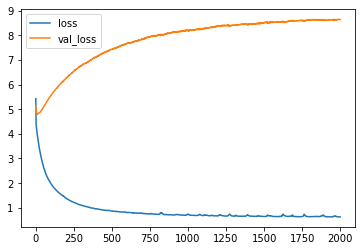

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

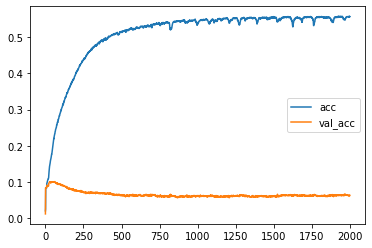

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [18]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [19]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [20]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [21]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

one mustn't bear too hard on the new comers,
they found he'd gnawed the four posts of our united strengths, to
make yourself up a cheering song of how
a cliff, and on the cliff a bottle painted,
---generate another? [Y/n]---y
over the ridgepole, 'stride of a broomstick,
at ten o'clock of a winter eve.
the poetess who wrote the book of verses
only i happen to prefer to live
---generate another? [Y/n]---n
